In [1]:
1+1

2

In [2]:
import geopandas as gpd
import sys
sys.path.append("..") # this is only required when the imports are a level above the current file, typically not required
import utilities
import zonalStatistics

/home/ben/miniconda3/envs/forestHealth/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
display(utilities.list_all_layers_in_geopackage('../inputs/selection.gpkg'))

['main']

In [4]:
gdf = gpd.read_file('../inputs/selection.gpkg', layer='main')
# gdf = gdf.iloc[:1024]
gdf.head()

,GRID_ID,intersects_plantation,geometry
0,CWB-3730,0,"MULTIPOLYGON (((16951932.407 -3150983.778, 169..."
1,CWD-3730,0,"MULTIPOLYGON (((16952520.973 -3150983.778, 169..."
2,CWF-3730,0,"MULTIPOLYGON (((16953109.539 -3150983.778, 169..."
3,CWH-3730,0,"MULTIPOLYGON (((16953698.106 -3150983.778, 169..."
4,CWJ-3730,0,"MULTIPOLYGON (((16954286.672 -3150983.778, 169..."


In [5]:
gdf.shape

(171768, 3)

In [5]:
# This fetches the STAC API URL from the resource metadata.
url = utilities.fetch_resource_metadata("../resources.json")['url']

# This fetches the name of the first sensor defined in the resource metadata.
sensor_name = utilities.fetch_resource_metadata("../resources.json")['sensors'][1]['name']

# This defines which bands to fetch from the STAC API based on the first sensor's band definitions.
bands = list(utilities.fetch_resource_metadata("../resources.json")['sensors'][1]['bands'][0].values())

# Bounds must be in EPSG 4326 for the STAC API search.
bounds = gdf.to_crs('EPSG:4326').total_bounds.tolist()

In [6]:
utilities.fetch_resource_metadata("../resources.json")['sensors'][1]['common_name']

'Sentinel-2B'

In [7]:
# This searches for data within the bounding box of the gdf and within the specified time range.
data = utilities.get_data_from_stac(url, bounds, sensor_name, bands, time_range="2024-05-13/2024-05-13")

Compute monthly here if required

In [ ]:
zonalStatistics.compute_zonal_stats_bands_vectorized(
    data_monthly=data,
    gdf=gdf.iloc[:1024],
    key_column_name='GRID_ID',
    bands=bands,
    output_dir="./verification_vectorised",
    overwrite=True)

Processing 12 time steps for 1024 features
Bands: ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3', 'oa_fmask']


  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
zonalStatistics.compute_zonal_stats_bands(
    data_monthly=data,
    gdf=gdf.iloc[:1024],
    key_column_name='GRID_ID',
    bands=bands,
    output_dir="./verification_standard",
    overwrite=True)

Starting zonal statistics computation for 1024 features
Output directory: verification_standard
Bands: ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3', 'oa_fmask']


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 1/1024 [00:10<2:52:14, 10.10s/it]/home/ben/miniconda3/envs/forestHealth/lib/python3.14/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
 97%|█████████▋| 996/1024 [3:37:13<06:06, 13.09s/it]    


KeyboardInterrupt: 

In [1]:
1+1

2

In [4]:
import combineCSV

In [5]:
combineCSV.compile_csvs(
    output_dir="./verification_standard",
    pattern="BANDS*.csv",
    combined_filename="verification_standard_combined.csv",
    key_column_name='GRID_ID',
    recursive=False,
    verbose=False)

Now that we have all of our data to work with we will proceed with some statistics, calculations, and plots.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
# arcpro = pd.read_excel('../inputs/ga_s2bm_oa_3-2-1_56JMR_2024-05-13_final.xlsx')
arcpro = pd.read_excel('../inputs/ga_s2bm_oa_3-2-1_56JMS_2024-05-13.xlsx')

In [82]:
arcpro.set_index('GRID_ID', inplace=True)

<Axes: >

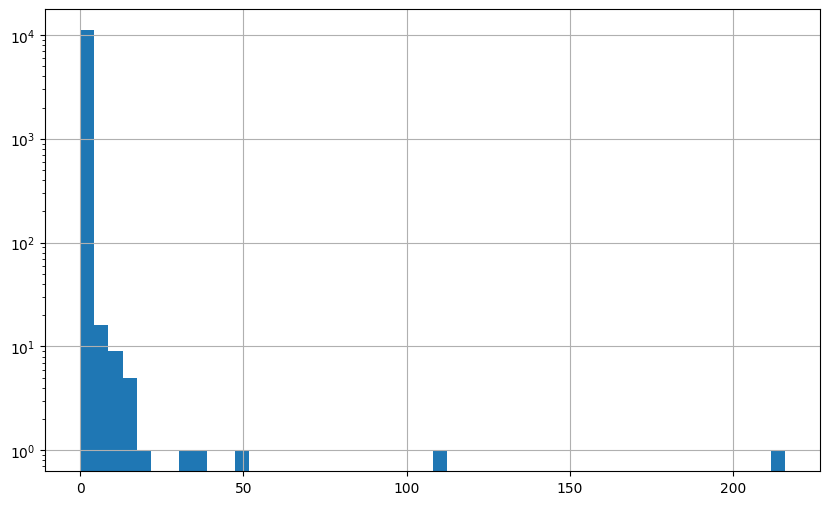

In [83]:
arcpro[arcpro['NDVI'] > 0]['NDVI'].hist(bins=50, log=True, figsize=(10,6))

array([[<Axes: title={'center': 'NDVI'}>]], dtype=object)

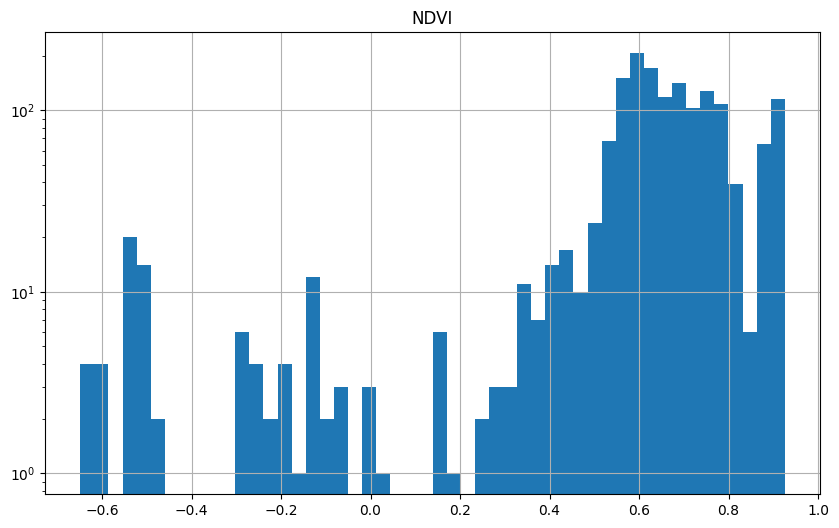

In [87]:
df = pd.read_csv('verification_standard/verification_standard_combined.csv', index_col='GRID_ID')
# df[['RG', 'nbartRG']].plot(legend=True, logy=False, figsize=(24,6))
df[df['NDVI'].notna()][['NDVI']].hist(bins=50, log=True, figsize=(10,6))

In [91]:
pd.concat([df[df['Duplicate'] == False], arcpro], axis=1)

,time,nbart_blue_mean,nbart_green_mean,nbart_red_mean,nbart_nir_1_mean,nbart_swir_2_mean,nbart_swir_3_mean,oa_fmask_mean,VARI,NDVI,...,nbart_red.AREA,nbart_red.MEAN,nbart_green.OBJECTID,nbart_green.GRID_ID,nbart_green.ZONE_CODE,nbart_green.COUNT,nbart_green.AREA,nbart_green.MEAN,VARI,NDVI
GRID_ID,,,,,,,,,,,,,,,,,,,,,
CWB-3730,04:23.0,175.46056,329.27990,217.27354,2330.7087,1179.3625,500.09286,1.0,0.301828,0.829454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CWC-3729,04:23.0,217.65997,418.40903,337.88960,2338.6875,1508.7227,718.44916,1.0,0.149487,0.747521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CWD-3729,04:23.0,307.48596,566.14290,531.11096,2646.4924,2031.2142,1037.74230,1.0,0.044357,0.665716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CWD-3730,04:23.0,257.33716,501.24554,428.10815,2625.8767,1841.9770,884.86896,1.0,0.108833,0.719640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CWE-3728,04:23.0,211.67049,361.15140,314.39185,2160.8613,1307.8829,597.61580,1.0,0.100803,0.745972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAM-4027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80695.562161,-62.136364,11515.0,DAM-4027,11515.0,22.0,80695.562161,-67.863636,-0.111901,1.116306
DHS-4027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77027.582063,-283.000000,11516.0,DHS-4027,11516.0,21.0,77027.582063,-351.285714,0.345792,-49.364407
DHU-4027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80695.562161,-505.181818,11518.0,DHU-4027,11518.0,22.0,80695.562161,-509.681818,0.009757,-1.061011


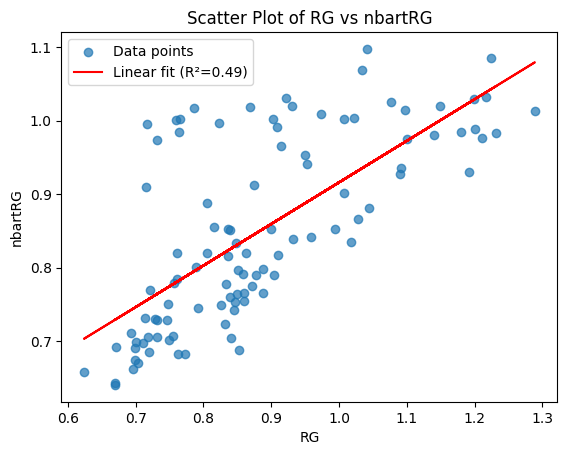

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Scatter plot
plt.scatter(df['RG'], df['nbartRG'], alpha=0.7, label='Data points')
plt.xlabel('RG')
plt.ylabel('nbartRG')
plt.title('Scatter Plot of RG vs nbartRG')

# Linear regression
X = df[['RG']].values  # Reshape to 2D array for sklearn
y = df['nbartRG'].values
model = LinearRegression()
model.fit(X, y)

# Predicted values
y_pred = model.predict(X)

# Plot regression line
plt.plot(df['RG'], y_pred, color='red', label=f'Linear fit (R²={r2_score(y, y_pred):.2f})')
plt.legend()
plt.show()